In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 12.2 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import os
import random
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()
#builder = tfds.builder('oxford_iiit_pet:3.*.*')
#builder.download_and_prepare()
#builder.as_dataset()

tfds.load('oxford_iiit_pet:3.*.*', with_info = True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


({'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
  'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>},
 tfds.core.DatasetInfo(
     name='oxford_iiit_pet',
     full_name='oxford_iiit_pet/3.2.0',
     description="""
     The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
     images for each class. The images ha

In [ ]:
input_dir = '/root/tensorflow_datasets/downloads/extracted/images/'
target_dir = '/root/tensorflow_datasets/downloads/extracted/annotations/trimaps/'

img_size = (160, 160)
n_class = 3 # 분류하고자 하는 class의 수
batch_size = 32

In [ ]:
img_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
label_paths = sorted([os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith('.png') and not f.startswith('.')])

In [ ]:
class OxfordPets(keras.utils.Sequence):
  # init 정보 입력
  def __init__(self, batch_size, img_size, img_paths, label_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_paths = img_paths
    self.label_paths = label_paths

  def __len__(self):
    return len(self.label_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_img_paths = self.img_paths[i:i+self.batch_size]
    batch_label_paths = self.label_paths[i:i+self.batch_size]

    x = np.zeros((self.batch_size,) + self.img_size+(3,), dtype = 'float32')
    for j, path in enumerate(batch_img_paths):
      img = load_img(path, target_size = self.img_size)
      x[j] = img

    y = np.zeros((self.batch_size,) + self.img_size+(1,), dtype = 'uint8')
    for j, path in enumerate(batch_label_paths):
      img = load_img(path, target_size = self.img_size, color_mode = "grayscale")
      y[j] = np.expand_dims(img, 2)
      y[j] -= 1 # 부류 번호를 1, 2, 3에서 0, 1, 2로 변환

    return x, y

In [ ]:
def conv2D_block(input_tensor, n_filters, kernel_size = 3):
  x = input_tensor
  for i in range(2):
    x = layers.SeparableConv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                               kernel_initializer = 'he_normal', padding = 'same')(x)

    x = layers.Activation('relu')(x)
  return x

# 필터 개수 수정 64 -> 32
def encoder_block(inputs, n_filters = 32, pool_size = (2, 2), dropout = 0.3):
  f = conv2D_block(inputs, n_filters = n_filters)
  p = layers.MaxPooling2D(pool_size=(2, 2))(f)
  p = layers.Dropout(dropout)(p)

  return f, p


def encoder(inputs):
  # 필터 수 점점 늘리기, 시작: 32
  f1, p1 = encoder_block(inputs, n_filters = 32, pool_size = (2, 2), dropout = 0.3)
  f2, p2 = encoder_block(p1, n_filters = 64, pool_size = (2, 2), dropout = 0.3)
  f3, p3 = encoder_block(p2, n_filters = 128, pool_size = (2, 2), dropout = 0.3)
  f4, p4 = encoder_block(p3, n_filters = 256, pool_size = (2, 2), dropout = 0.3)

  # 더해주기 위한 정보인 f1 ~ f4 return
  return p4, (f1, f2, f3, f4)

def bottleneck(inputs):
  # 마지막으로 늘려주기, 여기서는 풀링 수행 x
  # 최종 필터 개수: 512(기존 = 1024)
  bottle_neck = conv2D_block(inputs, n_filters = 512)

  return bottle_neck

# input과 연결할 정보(conv_output)을 지정해줌
def decoder_block(inputs, conv_output, n_filters = 32, kernel_size = 3, strides = 3, dropout = 0.3):
  u = layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = layers.concatenate([u, conv_output])
  c = layers.Dropout(dropout)(c)
  c = conv2D_block(c, n_filters, kernel_size = 3)
  return c

def decoder(inputs, convs, output_channels):
  # 연결할 정보 받아오기
  f1, f2, f3, f4 = convs

  # 절반으로 필터 수 줄여나가기(거꾸로 올라간다)
  # 최종 필터: 32
  c6 = decoder_block(inputs, f4, n_filters = 256, kernel_size = (3, 3), strides = (2, 2), dropout = 0.3)
  c7 = decoder_block(c6, f3, n_filters = 128, kernel_size = (3, 3), strides = (2, 2), dropout = 0.3)
  c8 = decoder_block(c7, f2, n_filters = 64, kernel_size = (3, 3), strides = (2, 2), dropout = 0.3)
  c9 = decoder_block(c8, f1, n_filters = 32, kernel_size = (3, 3), strides = (2, 2), dropout = 0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation = 'softmax')(c9)
  return outputs

def make_model(img_size, num_classes):
  inputs = keras.Input(shape = img_size+(3,))
  # conv + max pooling 수행하면서 채널 늘려나가기
  encoder_output, convs = encoder(inputs)

  # 최종적으로 수행한 encoder 결과 값에 필터 수가 1024개인 conv 수행하기
  bottle_neck = bottleneck(encoder_output)

  # 다시 채널을 줄여나가는 과정을 수행 - decoder
  # 최종적으로 출력할 class의 개수는 3개이므로 3으로 지정
  outputs = decoder(bottle_neck, convs, 3)

  # 모델 생성
  model = keras.Model(inputs = inputs, outputs = outputs)

  return model

In [ ]:
# 모델 생성
model = make_model(img_size, n_class)

random.Random(1).shuffle(img_paths)
random.Random(1).shuffle(label_paths)

# Use 20% by test
test_samples = int(len(img_paths)*0.20)
train_img_paths = img_paths[:-test_samples]
train_label_paths = label_paths[:-test_samples]
test_img_paths = img_paths[-test_samples:]
test_label_paths = label_paths[-test_samples:]

train_gen = OxfordPets(batch_size, img_size, train_img_paths, train_label_paths) # train
test_gen = OxfordPets(batch_size, img_size, test_img_paths, test_label_paths) # validation

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
cb = [keras.callbacks.ModelCheckpoint('oxford_seg.h5', save_best_only = True)] #학습 결과 저장

# 이전보다 필터의 수를 줄였으니 epoch을 늘려 20회로 학습
model.fit(train_gen, epochs = 20, validation_data = test_gen, callbacks = cb)

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.8912 - accuracy: 0.0838

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 [==============================] - 87s 356ms/step - loss: 0.8912 - accuracy: 0.0838 - val_loss: 0.7870 - val_accuracy: 0.2135
Epoch 2/20
184/184 [==============================] - 65s 353ms/step - loss: 0.7375 - accuracy: 0.3323 - val_loss: 0.6714 - val_accuracy: 0.4203
Epoch 3/20
184/184 [==============================] - 65s 354ms/step - loss: 0.6277 - accuracy: 0.3116 - val_loss: 0.5864 - val_accuracy: 0.3589
Epoch 4/20
184/184 [==============================] - 66s 358ms/step - loss: 0.5543 - accuracy: 0.3062 - val_loss: 0.5140 - val_accuracy: 0.2925
Epoch 5/20
184/184 [==============================] - 64s 350ms/step - loss: 0.5058 - accuracy: 0.3092 - val_loss: 0.4930 - val_accuracy: 0.3645
Epoch 6/20
184/184 [==============================] - 66s 357ms/step - loss: 0.4726 - accuracy: 0.3107 - val_loss: 0.4444 - val_accuracy: 0.3168
Epoch 7/20
184/184 [==============================] - 65s 352ms/step - loss: 0.4413 - accuracy: 0.3131 - val_loss: 0.4247 - val_accuracy: 0.3

46/46 [==============================] - 6s 130ms/step


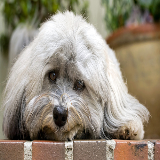

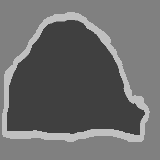

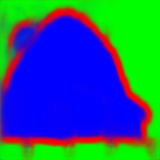

(160, 160, 3)


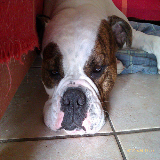

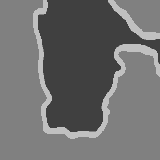

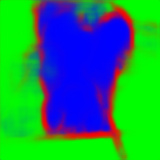

(160, 160, 3)


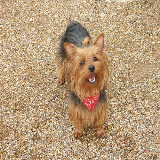

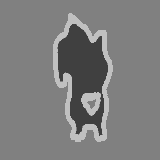

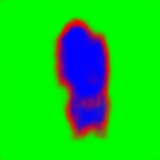

(160, 160, 3)


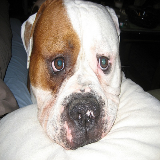

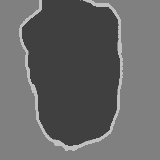

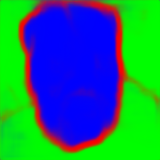

(160, 160, 3)


In [ ]:
from google.colab.patches import cv2_imshow

preds = model.predict(test_gen) #predict

# 임의로 랜덤한 정수를 지정해주었다.
for i in range(64, 68):
  img = cv.imread(test_img_paths[i])
  img = cv.resize(img, (160, 160))
  cv2_imshow(img)

  label = cv.imread(test_label_paths[i])
  label = cv.resize(label, (160, 160))

  cv2_imshow(label*64)

  cv2_imshow(preds[i]*255) # 각 class의 확률에 255를 곱하여 color 값 변환

  cv.waitKey()
  cv.destroyAllWindows()

  print(preds[i].shape)

In [ ]:
# 결과가 좋아보이지 않아 20epoch 추가학습
model_cb = tf.keras.models.load_model('/content/oxford_seg.h5')
model_cb.fit(train_gen, epochs = 20, validation_data = test_gen, callbacks = cb)

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.3126

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 [==============================] - 81s 379ms/step - loss: 0.3098 - accuracy: 0.3126 - val_loss: 0.3196 - val_accuracy: 0.3008
Epoch 2/20
184/184 [==============================] - 65s 353ms/step - loss: 0.3053 - accuracy: 0.3120 - val_loss: 0.3537 - val_accuracy: 0.3312
Epoch 3/20
184/184 [==============================] - 66s 357ms/step - loss: 0.2962 - accuracy: 0.3126 - val_loss: 0.3308 - val_accuracy: 0.3396
Epoch 4/20
184/184 [==============================] - 65s 351ms/step - loss: 0.2897 - accuracy: 0.3125 - val_loss: 0.3251 - val_accuracy: 0.2956
Epoch 5/20
184/184 [==============================] - 65s 350ms/step - loss: 0.2853 - accuracy: 0.3120 - val_loss: 0.3183 - val_accuracy: 0.3163
Epoch 6/20
184/184 [==============================] - 69s 375ms/step - loss: 0.2897 - accuracy: 0.3127 - val_loss: 0.3185 - val_accuracy: 0.3191
Epoch 7/20
184/184 [==============================] - 65s 355ms/step - loss: 0.2820 - accuracy: 0.3121 - val_loss: 0.3104 - val_accuracy: 0.3

46/46 [==============================] - 8s 173ms/step


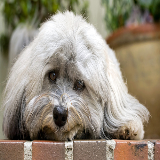

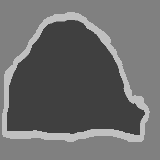

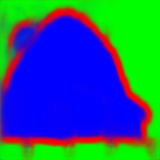

(160, 160, 3)


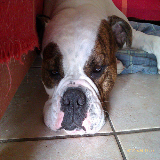

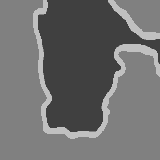

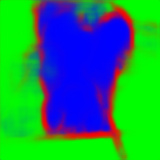

(160, 160, 3)


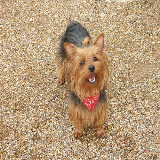

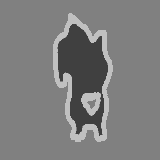

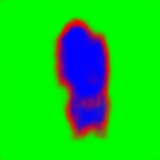

(160, 160, 3)


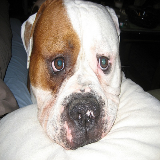

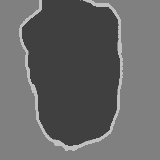

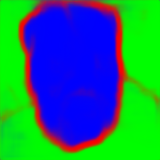

(160, 160, 3)


In [ ]:
# 확인해보기
preds = model.predict(test_gen) #predict

# 임의로 랜덤한 정수를 지정해주었다.
for i in range(64, 68):
  img = cv.imread(test_img_paths[i])
  img = cv.resize(img, (160, 160))
  cv2_imshow(img)

  label = cv.imread(test_label_paths[i])
  label = cv.resize(label, (160, 160))

  cv2_imshow(label*64)

  cv2_imshow(preds[i]*255) # 각 class의 확률에 255를 곱하여 color 값 변환

  cv.waitKey()
  cv.destroyAllWindows()

  print(preds[i].shape)

In [ ]:
# loss 그래프 그리기
# 주의 반드시 history값을 model에서 받아주기

history = model.fit(train_gen, epochs = 20, validation_data = test_gen, callbacks = cb)
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

NameError: ignored

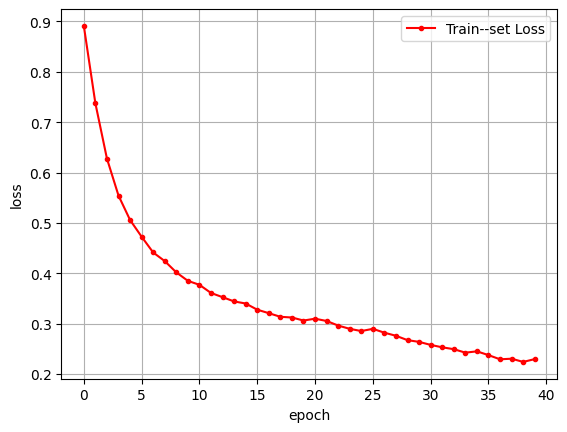

In [ ]:
loss = [0.8912, 0.7375, 0.6277, 0.5543, 0.5058 ,0.4726, 0.4413, 0.4242, 0.4018, 0.3850, 0.3771, 0.3609, 0.3526, 0.3441, 0.3400, 0.3277, 0.3208, 0.3136, 0.3122, 0.3062, 0.3098, 0.3053, 0.2962, 0.2897,
        0.2853, 0.2897, 0.2820, 0.2759, 0.2672, 0.2638, 0.2578, 0.2530, 0.2493, 0.2424, 0.2450, 0.2375, 0.2292, 0.2304, 0.2240 , 0.2296]

x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c='red', label="Train--set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()